# Sentiment Analysis with Deep Learning using BERT
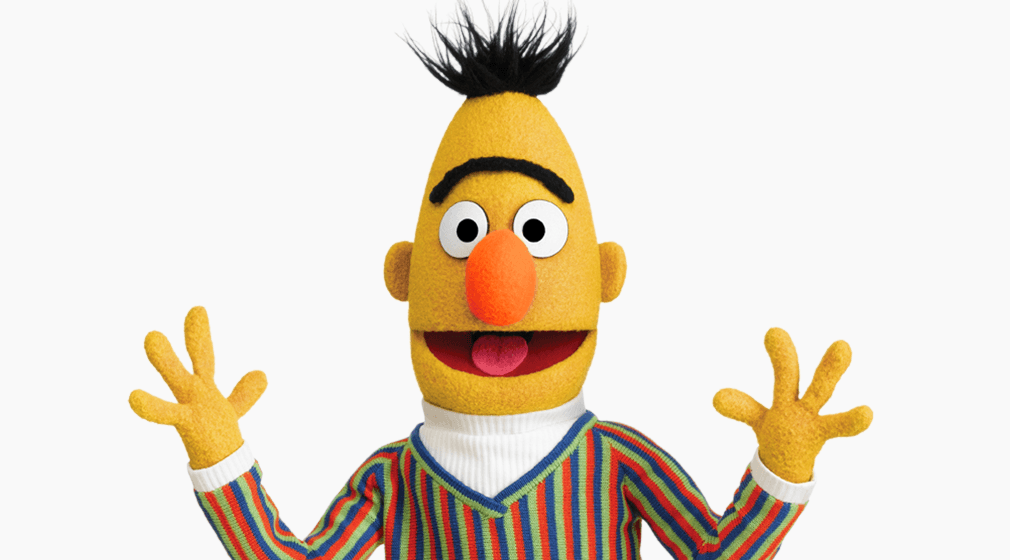

# Project Outline

**Task 1**: Introduction (this section)

**Task 2**: Exploratory Data Analysis and Preprocessing

**Task 3**: Training/Validation Split

**Task 4**: Loading Tokenizer and Encoding our Data

**Task 5**: Setting up BERT Pretrained Model

**Task 6**: Creating Data Loaders

**Task 7**: Setting Up Optimizer and Scheduler

**Task 8**: Defining our Performance Metrics

**Task 9**: Creating our Training Loop

## Introduction

In today's data-driven landscape, understanding the sentiment and emotions behind textual content has become paramount for businesses and researchers alike. From gauging customer sentiment on products to analyzing public opinions on policies, sentiment analysis helps in deriving actionable insights from raw, unstructured text.

This project leverages the power of BERT (Bidirectional Encoder Representations from Transformers) for sentiment analysis. BERT, since its inception, has revolutionized the way we handle language understanding tasks in machine learning. Its bidirectional approach — understanding each word in the context of its preceding and succeeding words — allows it to understand the intricacies and nuances of the English language.

Using the SMILE Twitter dataset, which is annotated for various sentiments, our goal is to fine-tune the BERT model to predict the sentiment behind each tweet. The workflow includes exploratory data analysis, preprocessing of textual data, setting up the BERT model, and finally, training and evaluating our model. 

This endeavor is not just a programming exercise, but an opportunity to understand and implement one of the most powerful NLP tools available in the domain. By the end of this project, we aim to have a deployable model that can predict sentiments with high accuracy.

### Prerequisites:
- Intermediate-level knowledge of Python 3 (preferably with exposure to libraries such as NumPy and Pandas)
- Familiarity with the PyTorch framework
- A basic understanding of Deep Learning concepts and, more specifically, transformer-based language models like BERT.

### References:
- [BERT original paper](https://arxiv.org/abs/1810.04805)
- [HuggingFace documentation](https://huggingface.co/transformers/model_doc/bert.html)
- For a bit of humor: [Bert documentation](https://characters.fandom.com/wiki/Bert_(Sesame_Street))

### Dataset:
The [SMILE Twitter dataset](https://figshare.com/articles/dataset/smile_annotations_final_csv/3187909/2) has been chosen due to its rich annotations, diversity in sentiments, and its relevance in today's social media-driven world.


## Exploratory Data Analysis and Preprocessing

In [1]:
# Importing necessary libraries
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
# Loading the data
df = pd.read_csv('/Users/Vlahonator/Downloads/smile-annotations-final.csv', names=['id', 'text', 'category'])
df.set_index('id', inplace=True)

In [3]:
# Displaying the head of the dataset
df.head()


,text,category
id,,
611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
614877582664835073,@Sofabsports thank you for following me back. ...,happy
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


In [4]:
# Checking value counts for each category
df["category"].value_counts()

nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: category, dtype: int64

In [5]:
# Removing any rows with '|' in the category and 'nocode'
df = df[~df.category.str.contains('\|')]

In [6]:
df = df[df.category != 'nocode']

In [7]:
# Displaying the cleaned category counts
df["category"].value_counts()

happy           1137
not-relevant     214
angry             57
surprise          35
sad               32
disgust            6
Name: category, dtype: int64

In [8]:
# Defining the labels
possible_labels = df.category.unique()

In [9]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [10]:
# Making new column with integer mapping from category column
df['label'] = df.category.replace(label_dict)

In [11]:
# New df
df.head()

,text,category,label
id,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0


## Training/Validation Split

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

In [14]:
df['data_type'] = ['not_set']*df.shape[0]

In [15]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [16]:
# Checking the distribution of data
df.groupby(['category', 'label', 'data_type']).count()

text
category     label data_type      
angry        2     train        48
                   val           9
disgust      3     train         5
                   val           1
happy        0     train       966
                   val         171
not-relevant 1     train       182
                   val          32
sad          4     train        27
                   val           5
surprise     5     train        30
                   val           5

## Loading Tokenizer and Encoding our Data

In [17]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [18]:
# Loading the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [19]:
# Encoding the data
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

In [20]:
# Creating PyTorch datasets
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [21]:
len(dataset_train)

1258

In [22]:
len(dataset_val)

223

## Setting up BERT Pretrained Model

In [23]:
from transformers import BertForSequenceClassification

In [24]:
# Loading the model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



## Creating Data Loaders

In [25]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [26]:
# Setting the batch size
batch_size = 32
# Creating the DataLoaders
dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

## Setting Up Optimiser and Scheduler

In [137]:
# Importing necessary libraries for optimizer and learning rate scheduler
from transformers import AdamW, get_linear_schedule_with_warmup

In [138]:
# Setting up the AdamW optimizer for the model
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [139]:
epochs = 3
# Setting up the learning rate scheduler with warmup
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## Defining our Performance Metrics

Accuracy metric approach originally used in accuracy function in [this tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification).

In [140]:
import numpy as np

In [141]:
from sklearn.metrics import f1_score

In [142]:
# Defining the f1 score calculation function
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [147]:
# Function to compute accuracy for each class
def accuracy_per_class(preds, labels):
    # Creating an inverse dictionary for labels (value to key mapping)
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    # Convert the predicted probabilities to predicted class indices
    preds_flat = np.argmax(preds, axis=1).flatten()
    
    # Flatten the true labels
    labels_flat = labels.flatten()

    # Iterate over each unique label in the true labels
    for label in np.unique(labels_flat):
        # Extract predicted labels corresponding to the current 'label' from true labels
        y_preds = preds_flat[labels_flat==label]
        
        # Extract true labels corresponding to the current 'label'
        y_true = labels_flat[labels_flat==label]
        
        # Display the class name using the inverse dictionary
        print(f'Class: {label_dict_inverse[label]}')
        
        # Display the accuracy for the current class: 
        # Number of correctly predicted samples / Total samples of the class
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')


## Creating our Training Loop

Approach adapted from an older version of HuggingFace's `run_glue.py` script. Accessible [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128).

In [143]:
# Setting a manual seed for reproducibility across various functions
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [144]:
# Determining if CUDA is available and moving the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cpu


In [145]:
# Function to evaluate the model on validation data
def evaluate(dataloader_val):
    # Set the model to evaluation mode to disable dropout and batch normalization layers
    model.eval()
    
    # Initialize the total validation loss to zero
    loss_val_total = 0
    
    # Lists to store the predicted logits and true label values for all batches
    predictions, true_vals = [], []
    
    # Loop over each batch in the validation dataloader
    for batch in dataloader_val:
        
        # Transfer the batch tensors to the device (either 'cuda' or 'cpu')
        batch = tuple(b.to(device) for b in batch)
        
        # Organize inputs as a dictionary for easy unpacking inside the model
        inputs = {
            'input_ids':      batch[0],
            'attention_mask': batch[1],
            'labels':         batch[2],
        }

        # Disable gradient computations for evaluation (saves memory and speeds up computation)
        with torch.no_grad():        
            outputs = model(**inputs)
            
        # Extract the loss and logits from the model's outputs
        loss = outputs[0]
        logits = outputs[1]
        
        # Increment the total validation loss
        loss_val_total += loss.item()

        # Detach the logits from the computation graph and convert them to numpy arrays
        logits = logits.detach().cpu().numpy()
        
        # Convert the true label ids to numpy arrays
        label_ids = inputs['labels'].cpu().numpy()
        
        # Append the logits and true label ids for this batch to the lists
        predictions.append(logits)
        true_vals.append(label_ids)
    
    # Calculate the average validation loss over all batches
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    # Concatenate the logits and true labels from all batches into single arrays
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    # Return the average validation loss, predicted logits, and true label values
    return loss_val_avg, predictions, true_vals


In [146]:
# Training loop for epochs
for epoch in tqdm(range(1, epochs+1)):
    
    # Set the model to training mode to enable dropout and batch normalization layers
    model.train()
    
    # Initialize the total training loss to zero for this epoch
    loss_train_total = 0

    # Display a progress bar for batches within this epoch
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    
    # Loop over each batch in the training dataloader
    for batch in progress_bar:

        # Zero out any previously computed gradients in the model
        model.zero_grad()
        
        # Transfer the batch tensors to the device (either 'cuda' or 'cpu')
        batch = tuple(b.to(device) for b in batch)
        
        # Organize inputs as a dictionary for easy unpacking inside the model
        inputs = {
            'input_ids':      batch[0],
            'attention_mask': batch[1],
            'labels':         batch[2],
        }       

        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(**inputs)
        
        # Extract the training loss from the model's outputs
        loss = outputs[0]
        
        # Increment the total training loss for this epoch
        loss_train_total += loss.item()
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Clip gradients to prevent "exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update model parameters using the optimizer
        optimizer.step()
        
        # Update learning rate using the scheduler
        scheduler.step()
        
        # Display the training loss for this batch on the progress bar
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    # Save the model's state after this epoch
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    # Display the epoch number in the console
    tqdm.write(f'\nEpoch {epoch}')
    
    # Calculate and display the average training loss for this epoch
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    # Evaluate the model on the validation dataset after this epoch
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    
    # Compute the weighted F1 score on the validation dataset
    val_f1 = f1_score_func(predictions, true_vals)
    
    # Display the validation loss and F1 score in the console
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')



Epoch 1
Training loss: 0.7238405920565129
Validation loss: 0.6993163057735988
F1 Score (Weighted): 0.7407933426764294


KeyboardInterrupt: 

In [60]:
# Initializing the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

In [149]:
# Loading the saved state of the model

model.load_state_dict(torch.load('Models/BERT_ft_epoch2.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [150]:
# Evaluating model on validation set
_, predictions, true_vals = evaluate(dataloader_validation)

In [151]:
# Getting accuracy per class
accuracy_per_class(predictions, true_vals)

Class: happy
Accuracy: 163/171

Class: not-relevant
Accuracy: 20/32

Class: angry
Accuracy: 7/9

Class: disgust
Accuracy: 0/1

Class: sad
Accuracy: 4/5

Class: surprise
Accuracy: 2/5



## Conclusion 

Throughout this project, I delved deep into the nuances of Natural Language Processing using state-of-the-art models like BERT. I tailored the model to the dataset, ensuring the relevance and effectiveness of my predictions. By fine-tuning BERT for this specific task, I leveraged its vast knowledge from pre-training while customizing it for our unique requirements. The metrics, including training loss, validation loss, and F1 score, provided a comprehensive understanding of the model's performance.

An additional insight into the model's performance can be gathered from the class-wise accuracies:
- **Happy:** 163/171 (95.3%)
- **Not-relevant:** 20/32 (62.5%)
- **Angry:** 7/9 (77.8%)
- **Disgust:** 0/1 (0%)
- **Sad:** 4/5 (80%)
- **Surprise:** 2/5 (40%)

These accuracies highlight the areas where the model excelled and where there's potential for improvement.

As I look forward to future projects, it would be beneficial to explore additional optimization techniques, experiment with different model architectures, and potentially leverage more data. The journey of model refinement is continuous, but the strides I've made here set a strong foundation for my future endeavors in NLP.


In [1]:
pwd

'/Users/Vlahonator/Downloads/Sentiment Analysis Using BERT'